<a href="https://colab.research.google.com/github/Dmitri9149/TensorFlow_PyTorch_CNN/blob/main/TensorFlow_LeNet_AvgPooling_Sigmoid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -U: Upgrade all packages to the newest available version
!pip install -U d2l
from d2l import tensorflow as d2l
import tensorflow as tf
from tensorflow.distribute import MirroredStrategy, OneDeviceStrategy
from matplotlib import pyplot
from keras.datasets import fashion_mnist


     |████████████████████████████████| 61kB 4.7MB/s 


### Convolutional Neural Network LeNet.

This is implementation of classical LeNet convolutional neural network , originally designed for handwritten digit recignition. 

The basic architecture is used for some experimentation: 
we may change AveragePooling to MaxPooling and Sigmoid to ReLu activations. It is interesting to check, how it will change the results.

I use some code from d2l.ai : http://d2l.ai/ 

There is also some intermediate code with experimentation with TensorFlow objects.

## In this version we use Average Pooling and Sigmoid.



In [2]:
## part of code from d2l.ai
def LN():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='sigmoid',
                               padding='same'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=5,
                               activation='sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='sigmoid'),
        tf.keras.layers.Dense(84, activation='sigmoid'),
        tf.keras.layers.Dense(10)])

In [3]:
X = tf.zeros((1,28,28,1))
for layer in LN().layers:
  X = layer(X)
  print(layer.__class__.__name__,'           output shape \t', X.shape)

Conv2D            output shape 	 (1, 28, 28, 6)
AveragePooling2D            output shape 	 (1, 14, 14, 6)
Conv2D            output shape 	 (1, 10, 10, 16)
AveragePooling2D            output shape 	 (1, 5, 5, 16)
Flatten            output shape 	 (1, 400)
Dense            output shape 	 (1, 120)
Dense            output shape 	 (1, 84)
Dense            output shape 	 (1, 10)


### Data 


We will use FASHION-MNIST dataset. 

In [4]:
(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [5]:
print('Train : {} , {}'.format(train_X.shape, train_y.shape))
print('Test : {} , {}'.format(test_X.shape, test_y.shape))

Train : (60000, 28, 28) , (60000,)
Test : (10000, 28, 28) , (10000,)


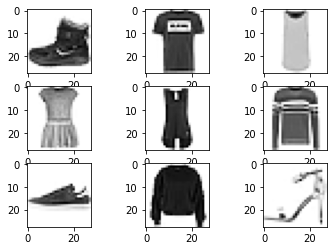

In [6]:
for i in range(9):
  pyplot.subplot(3,3,1 + i)
  pyplot.imshow(train_X[i], cmap = pyplot.get_cmap('Greys'))
pyplot.show()

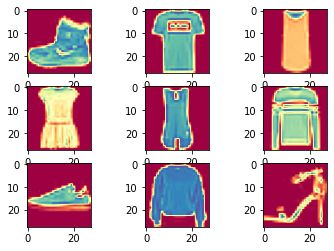

In [7]:
for i in range(9):
  pyplot.subplot(3,3,1 + i)
  pyplot.imshow(train_X[i], cmap = pyplot.get_cmap('Spectral'))
pyplot.show()

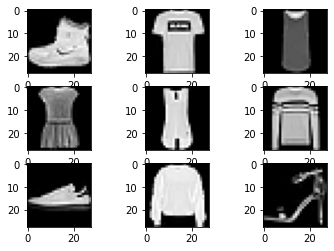

In [8]:
for i in range(9):
  pyplot.subplot(3,3,1 + i)
  pyplot.imshow(train_X[i], cmap = pyplot.get_cmap('gray'))
pyplot.show()

In [9]:
def reshape_cast(X,y):
  # scale to [0,1] interval, add dim=3 ->  will be single colour channel
  return (tf.expand_dims(X,axis=3)/255, tf.cast(y,dtype='int32'))

def load_data_fashion_mnist(batch_size):
  return (
      tf.data.Dataset.from_tensor_slices(reshape_cast(*(train_X,train_y)))
      .batch(batch_size).shuffle(len(train_X)),
      tf.data.Dataset.from_tensor_slices(reshape_cast(*(test_X,test_y)))
      .batch(batch_size)
      
  )

In [10]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)

In [11]:
# from d2l.ai
class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [12]:
# from d2l.ai
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [13]:
# from d2l.ai
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if len(tf.config.experimental.list_physical_devices('GPU')) >= i + 1:
        return tf.device(f'/GPU:{i}')
    return tf.device('/CPU:0')

In [14]:
# from d2l.ai
class TrainCallback(tf.keras.callbacks.Callback):
    """A callback to visiualize the training progress."""
    def __init__(self, net, train_iter, test_iter, num_epochs, device_name):
        self.timer = d2l.Timer()
        self.animator = d2l.Animator(
            xlabel='epoch', xlim=[1, num_epochs], legend=[
                'train loss', 'train acc', 'test acc'])
        self.net = net
        self.train_iter = train_iter
        self.test_iter = test_iter
        self.num_epochs = num_epochs
        self.device_name = device_name
    def on_epoch_begin(self, epoch, logs=None):
        self.timer.start()
    def on_epoch_end(self, epoch, logs):
        self.timer.stop()
        test_acc = self.net.evaluate(
            self.test_iter, verbose=0, return_dict=True)['accuracy']
        metrics = (logs['loss'], logs['accuracy'], test_acc)
        self.animator.add(epoch + 1, metrics)
        if epoch == self.num_epochs - 1:
            batch_size = next(iter(self.train_iter))[0].shape[0]
            num_examples = batch_size * tf.data.experimental.cardinality(
                self.train_iter).numpy()
            print(f'loss {metrics[0]:.3f}, train acc {metrics[1]:.3f}, '
                  f'test acc {metrics[2]:.3f}')
            print(f'{num_examples / self.timer.avg():.1f} examples/sec on '
                  f'{str(self.device_name)}')

def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    device_name = device._device_name
    strategy = tf.distribute.OneDeviceStrategy(device_name)
    with strategy.scope():
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        net = net_fn()
        net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    callback = TrainCallback(net, train_iter, test_iter, num_epochs,
                             device_name)
    net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[callback])
    return net

loss 0.256, train acc 0.905, test acc 0.869
83015.6 examples/sec on /GPU:0


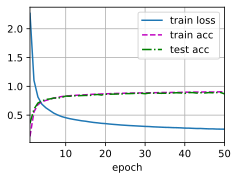

In [15]:
lr, num_epochs = 0.9, 50
train_ch6(LN, train_iter, test_iter, num_epochs, lr)